<img src='images/Joint_school_graphic_title.png' align='center' width='100%'></img>

# Data Assimilation Tutorial

This practical exercise was created for the <a href ="https://atmosphere.copernicus.eu/3rd-eumetsatesaecmwf-joint-training-atmospheric-composition" target = "_blank">3rd EUMETSAT/ESA/ECMWF Joint Training in Atmospheric Composition (6-17 December, 2021)</a> to show the assimilation of NO<sub>2</sub> observations from the TROPOspheric Monitoring Instrument (TROPOMI) aboard Sentinel 5-P into the forecasts of the Copernicus Atmosphere Monitoring Service (CAMS). It is divided into the following sections:

1. [Installation](#installation): A brief guide to know how to install the <a href = "https://github.com/esowc/adc-toolbox/" target = "_blank">Atmospheric Datasets Comparison (ADC) Toolbox</a>, which contains functions that facilitate the datasets retrieval, metadata merge and statistical analysis.

2. [Datasets retrieval](#datasets_retrieval): The model and sensor datasets are downloaded and read as xarray objects before assimilating the real observations into the model dataset.

3. [Data assimilation](#data_assimilation): The model partial columns are interpolated into the TM5 grid and the averaging kernels are applied.

4. [Comparison analysis](#comparison_analysis): Statistical methods are used to better understand the differences between both datasets and the effects of the data assimilation process.

## <a id='installation'></a>1. Installation

### Clone the repository and set up the virtual environment

Participants should <a href = "https://my.wekeo.eu/web/guest/user-registration" target = "_blank">create an account in Wekeo</a> to use the JupyterHub and run this notebook. Once they <a href = "https://jupyterhub-wekeo.apps.eumetsat.dpi.wekeo.eu" target = "_blank">have access to this service</a>, they can open the terminal, or an empty Jupyter Notebook, and clone the ADC Toolbox repository with the command:

```bash
$ git clone https://github.com/esowc/adc-toolbox
```

The virtual environment <em>environment.yml</em> was generated to simplify the installation process, so users just need to activate this environment or simulate it by installing the dependencies (libraries and packages) with:

```bash
$ cd adc-toolbox
$ conda create --name adc-toolbox
$ conda activate adc-toolbox
$ conda install -c conda-forge/label/cartopy_dev cartopy
$ pip install -r requirements.txt
$ python -m ipykernel install --user --name adc-toolbox
```

After running the previous commands, the page should be refreshed and the correct kernel (adc-toolbox) should be selected.

To finalize the installation process, users need to create a text file in the <em>data</em> folder, with the name <em>keys.txt</em>, and write down their personal CAMS API key in one line with the format <em>UID:Key</em>. Otherwise, they can introduce their user ID and key in the cell underneath. This key can be obtained by <a href = "https://ads.atmosphere.copernicus.eu/user/register?">registering at the Atmosphere Data Store</a>.

In [1]:
CAMS_UID = 'xxxx'
CAMS_key = 'yyyyyyyy-yyyy-yyyy-yyyy-yyyyyyyyyyyy'

### Import libraries

In [2]:
# Related to the system
import os 
from pathlib import Path

# Related to the data retrieval
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import geojson
import urllib3

# Related to the data analysis
import math
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product
import scipy.interpolate
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist

# Related to the results
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display

### Import functions

In [3]:
%run ../../functions/functions_general.ipynb
%run ../../functions/functions_cams.ipynb
%run ../../functions/functions_tropomi.ipynb

### Settings

In [4]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

## <a id='datasets_retrieval'></a>2. Datasets retrieval

### Available datasets

ADC Toolbox facilitates the data retrieval of all the datasets presented in Table 1, since the dates they became available to the public. As an exception, the retrieval of IASI L2 data is currently available only since May 14, 2019.

<p align="center"> <b>Table 1</b>. Temporal availability (start date - present) by data source.</p>

| Dataset | Type | NO<sub>2</sub> | O<sub>3</sub> | CO | SO<sub>2</sub> | HCHO |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| CAMS  | <a href = "https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/CAMS-global-atmospheric-composition-forecasts" target = "_blank">Forecast</a> | 01.2015 | 01.2015 | 01.2015 | 01.2015 | 01.2015 | 
| CAMS  | <a href = "https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/CAMS-global-ghg-reanalysis-egg4-monthly">Reanalysis</a> | 01.2003 | 01.2003 | 01.2003 | 01.2003 | 01.2003 | 
| TROPOMI  | <a href = "https://s5phub.copernicus.eu/dhus/" target = "_blank">L2</a> | 07.2018 | 07.2018 | 07.2018 | 10.2018 | - | 
| IASI  | <a href = "https://iasi.aeris-data.fr/" target = "_blank">L2</a> | - | 01.2008 | 10.2007 | 10.2007 | - |
| IASI  | <a href = "https://iasi.aeris-data.fr/" target = "_blank">L3</a> | - | 01.2008 | 10.2007 | 10.2007 | - |
| GOME-2  | <a href = "https://acsaf.org/offline_access.php" target = "_blank">L2</a> | 01.2007 | 01.2007 | - | 01.2007 | 01.2007 | 
| GOME-2  | <a href = "https://acsaf.org/offline_access.php" target = "_blank">L3</a> | 02.2007 | 01.2007 | - | 01.2007 | 01.2007 | 

Sentinel 5-P was launched in 2017 and, as it can be read in the table, the L2 products are accessible since:

* July 2018 for NO<sub>2</sub>, O<sub>3</sub> and CO concentrations.
* October 2018 for SO<sub>2</sub> concentrations.

In order to automatically download any model or sensor dataset, users only need to define:

* Name of the atmospheric component.
* Short (<em>cams</em>) and full name of the model (<em>cams-global-atmospheric-composition-forecasts</em> or <em>cams-global-reanalysis-eac4-monthly</em>).
* Short name of the sensor (<em>tropomi</em>, <em>iasi</em> or <em>gome</em>).
* Start and end date: a range will be calculated from both dates.
* Bounding box by coordinates.

<ins>Note</ins>: The sensor dataset to be downloaded should be Near Real-Time (observed within the last month) to contain the necessary data to apply the averaging kernels. 

In [5]:
# Define component
component_nom = 'NO2'

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Define sensor
sensor = 'tropomi'
sensor_type = 'L2'
apply_kernels = True

# Define search period
start_date = '2021-11-19'
end_date = '2021-11-19'

# Define extent
lon_min = 1.5
lon_max = 2.5
lat_min = 41
lat_max = 42

### Comparison checker and folder generation

The toolbox will check if the merge and comparison between the specified model and sensor is possible, given the name of the species. If it is, the molecular weight and some metadata will be obtained. Afterwards, it will create the folders where the datasets will be stored.

This notebook can only be used to show the data assimilation, please refer to the main code in case you wish to compare the CAMS model against the observations from IASI or GOME-2.

In [6]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


### Search period and bounding box

The search period and bounding box are derived from the details that were provided in advance.

In [7]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In days: [('2021-11-19T00:00:00Z', '2021-11-19T23:00:00Z')]
SEARCH BOUNDING BOX
Latitudes: from 41 to 42
Longitudes: from 1.5 to 2.5


### Download and read the model data

The model dataset will be downloaded as a GRIB file and read as a xarray object. In this step, the users can decide if they want to retrieve total (<em>model_level = 'Single'</em>) or partial columns (<em>model_level = 'Multiple'</em>). In the data assimilation process, we need to obtain the partial columns and, in this case, at 137 vertical levels.

In [8]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, 
                                               component_nom, model_full_name, model_level = 'Multiple')

The file exists, it will not be downloaded again.


In [9]:
model_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

### Download and read sensor data

The sensor dataset will be downloaded as a NetCDF file and read as a xarray object, along with more detailed and support datasets. More information about this product can be found in the <a href = "https://sentinels.copernicus.eu/documents/247904/2474726/Sentinel-5P-Level-2-Product-User-Manual-Nitrogen-Dioxide.pdf/ad25ea4c-3a9a-3067-0d1c-aaa56eb1746b?t=1626258361795" target = "_blank">TROPOMI NO<sub>2</sub> product manual</a>.

In [ ]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, bbox, product_type)

RESULTS
For ('2021-11-19T00:00:00Z', '2021-11-19T23:00:00Z'):
You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-12-02 23:28:27,214 INFO Found 2 products


Number 0-S5P_NRTI_L2__NO2____20211119T134750_20211119T135250_21255_02_020301_20211119T144631
Number 1-S5P_NRTI_L2__NO2____20211119T120750_20211119T121250_21254_02_020301_20211119T131758


2021-12-02 23:28:28,984 INFO Downloading a7487f85-de89-47fc-a855-85574fbd1702 to /home/alba/adc-toolbox/data/tropomi/NO2/2021-11-19/S5P_NRTI_L2__NO2____20211119T134750_20211119T135250_21255_02_020301_20211119T144631.nc


SELECTED
File name: a7487f85-de89-47fc-a855-85574fbd1702
Product name: S5P_NRTI_L2__NO2____20211119T134750_20211119T135250_21255_02_020301_20211119T144631.nc
The file does not exist, it will be downloaded.


Downloading:   0%|          | 0.00/62.5M [00:00<?, ?B/s]

MD5 checksumming:   0%|          | 0.00/62.5M [00:00<?, ?B/s]

In [ ]:
sensor_ds, support_input_ds, support_details_ds = sensor_read(sensor, sensor_type, sensor_column, 
                                                              component_nom, dates)

In [ ]:
sensor_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 373, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...

Within <em>support_input_ds</em> we can find the surface pressure data that we need to compute the pressure at each level, while <em>support_details_ds</em> contains the processing quality flags and air mass factors to calculate the column kernels.

In [ ]:
support_input_ds

<xarray.Dataset>
Dimensions:                                (ground_pixel: 450, scanline: 373, time: 1)
Coordinates:
  * time                                   (time) datetime64[ns] 2021-11-19
  * scanline                               (scanline) float64 0.0 1.0 ... 372.0
  * ground_pixel                           (ground_pixel) float64 0.0 ... 449.0
Data variables: (12/18)
    surface_altitude                       (time, scanline, ground_pixel) float32 ...
    surface_altitude_precision             (time, scanline, ground_pixel) float32 ...
    surface_classification                 (time, scanline, ground_pixel) float32 ...
    instrument_configuration_identifier    (time, scanline) float64 14.0 ... ...
    instrument_configuration_version       (time, scanline) float32 16.0 ... ...
    scaled_small_pixel_variance            (time, scanline, ground_pixel) float32 ...
    ...                                     ...
    cloud_fraction_crb                     (time, scanline, ground_pixel) float32 ...
    cloud_albedo_crb                       (time, scanline, ground_pixel) float32 ...
    scene_albedo                           (time, scanline, ground_pixel) float32 ...
    apparent_scene_pressure                (time, scanline, ground_pixel) float32 ...
    snow_ice_flag                          (time, scanline, ground_pixel) float32 ...
    aerosol_index_354_388                  (time, scanline, ground_pixel) float32 ...

In [ ]:
support_details_ds

<xarray.Dataset>
Dimensions:                                                (ground_pixel: 450, intensity_offset_polynomial_exponents: 1, polynomial_exponents: 6, scanline: 373, time: 1)
Coordinates:
  * time                                                   (time) datetime64[ns] ...
  * scanline                                               (scanline) float64 ...
  * ground_pixel                                           (ground_pixel) float64 ...
Dimensions without coordinates: intensity_offset_polynomial_exponents, polynomial_exponents
Data variables: (12/45)
    processing_quality_flags                               (time, scanline, ground_pixel) float64 ...
    number_of_spectral_points_in_retrieval                 (time, scanline, ground_pixel) float32 ...
    number_of_iterations                                   (time, scanline, ground_pixel) float64 ...
    wavelength_calibration_offset                          (time, scanline, ground_pixel) float32 ...
    wavelength_calibration_offset_precision                (time, scanline, ground_pixel) float32 ...
    wavelength_calibration_stretch                         (time, scanline, ground_pixel) float32 ...
    ...                                                     ...
    degrees_of_freedom                                     (time, scanline, ground_pixel) float32 ...
    air_mass_factor_stratosphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_cloudy                                 (time, scanline, ground_pixel) float32 ...
    air_mass_factor_clear                                  (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_ghost_column                           (time, scanline, ground_pixel) float32 ...
    cloud_selection_flag                                   (time, scanline, ground_pixel) float32 ...

## <a id='data_assimilation'></a>3. Data assimilation

During the data assimilation process, we will apply the sensor averaging kernels to the model partial columns in the observations space (TM5). Currently, we have data at different levels and grid resolutions. As you can see in the image below, the sensor collects data at 34 vertical layers, which are broader than the 137 levels in the CAMS model.

<img src='images/Vertical_resolutions.png' align='center' width='70%'></img>

<b>Figure 1.</b> L137 and TM5 levels by pressure.


### Steps

Following the next steps, we can retrieve the model partial columns at the TM5 grid and carry out the satellite data assimilation:
1. Calculate model levels pressure (L137).
2. Convert model data units (from kg/kg to molecules/cm<sup>2</sup>) and compute the partial columns above each half level. 
3. Calculate TM5 levels pressure and column kernels
4. Convert sensor data units (from kg/m<sup>2</sup> to molecules/cm<sup>2</sup>).
5. Transform sensor dataset into dataframe.
6. Integrate CAMS pressure levels into the dataframe.
7. Retrieve CAMS partial columns above each level at TM5 grid (closest neighbours).
8. Interpolate CAMS partial columns above each level at TM5 pressures.
9. Apply averaging kernels.
10. Calculate total columns for both datasets and difference between them.

### Calculate the model levels pressure

The 137 vertical levels in the model can be described by various parameters, which are necessary to evaluate the levels pressure. In particular, the coefficients <em>a</em> and <em>b</em> are used, as indicated in the <a href = "https://confluence.ecmwf.int/display/OIFS/4.4+OpenIFS%3A+Vertical+Resolution+and+Configurations">Confluence page about the vertical resolution and configuration of the model</a>, to calculate these pressures:

<center>
<em>p<sub>k+½</sub> = a<sub>k+½</sub> + p<sub>s</sub> · b<sub>k+½</sub></em><br>
<em>p<sub>k-½</sub> = a<sub>k-½</sub> + p<sub>s</sub> · b<sub>k-½</sub></em><br>
<em>p<sub>k</sub> = 0.5 · (p<sub>k-½</sub> + p<sub>k+½</sub>)</em>
</center>

In [ ]:
model_levels_df = CAMS_137_levels()
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],ph-diff [Pa],Depth [m]
hybrid,,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,1.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,1.57,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2.16,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2.92,2320.96
...,...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,341.69,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,313.12,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,286.77,22.96


In [ ]:
# Calculate level pressures from the surface pressures
model_ds = CAMS_pressure(model_ds, model_levels_df, start_date, end_date, component_nom)
model_ds

2021-12-02 23:28:45,689 INFO Welcome to the CDS
2021-12-02 23:28:45,689 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2021-12-02 23:28:45,703 INFO Request is queued


The surface pressures will be downloaded...


2021-12-02 23:28:46,711 INFO Request is running
2021-12-02 23:28:50,479 INFO Request is completed
2021-12-02 23:28:50,480 INFO Downloading https://download-0003.copernicus-atmosphere.eu/cache-compute-0003/cache/data9/adaptor.mars_constrained.internal-1638487728.4822547-4934-5-3000bda9-293c-4199-82ce-9f576d8ae687.grib to /home/alba/adc-toolbox/data/cams/NO2/surface-pressure-2021-11-19-2021-11-19.grib (6.2M)
2021-12-02 23:28:50,616 INFO Download rate 45.7M/s


<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 3, longitude: 3, step: 8, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 2021-11-19
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 41.2 41.6 42.0
  * longitude   (longitude) float64 1.6 2.0 2.4
    valid_time  (step) datetime64[ns] 2021-11-19 ... 2021-11-19T21:00:00
Data variables:
    component   (time, step, hybrid, latitude, longitude) float32 3.868e-09 ....
    pressure    (hybrid, time, step, latitude, longitude) float64 1.0 ... 9.5...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-02T23:28 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert the model data units (from kg/kg to molecules/cm<sup>2</sup>)

#### Calculate the columns above each half level (kg/kg to kg/m<sup>2</sup>)
To convert the original units (kg/kg) into kg/m<sup>2</sup>, we calculate the NO<sub>2</sub> columns above each CAMS half level, assuming that they are 0 at the top of the atmosphere.

In [ ]:
print('The columns above each model half level will be calculated.')

# Initialize new array
model_ds_all = []

for time in model_ds.time:

    PC_hybrid = []
    
    model_ds_time_old = model_ds.sel(time = time)

    # Initialize partial columns at the top of the atmosphere as 0
    PC_hybrid_0 = model_ds_time_old.sel(hybrid = 1)
    PC_hybrid_0['component'] = PC_hybrid_0['component'].where(PC_hybrid_0['component'] <= 0, 0, drop = False)
    PC_hybrid_0 = PC_hybrid_0.expand_dims(dim = ['hybrid'])
    PC_hybrid.append(PC_hybrid_0)
    model_ds_time_new = PC_hybrid_0

    for hybrid in range(1, 136):

        # Calculate partial columns above each model level
        PC_last = model_ds_time_new.component.sel(hybrid = hybrid)
        PC_current = model_ds_time_old.component.sel(hybrid = hybrid + 1)
        pressure_last = model_ds_time_old.pressure.sel(hybrid = hybrid)
        pressure_current = model_ds_time_old.pressure.sel(hybrid = hybrid + 1)
        pressure_diff = pressure_current - pressure_last

        # Units: (kg/kg * kg/m*s2) * s2/m -> kg/m2
        PC_above = model_ds_time_old.sel(hybrid = hybrid + 1)
        PC_above['component'] = PC_last + PC_current * pressure_diff * (1/9.81)
        PC_hybrid.append(PC_above)
        model_ds_time_new = xr.concat(PC_hybrid, pd.Index(range(1, hybrid + 2), name = 'hybrid'))

    model_ds_all.append(model_ds_time_new)

model_ds = xr.concat(model_ds_all, dim = 'time')
model_ds

The columns above each model half level will be calculated.


<xarray.Dataset>
Dimensions:     (hybrid: 136, latitude: 3, longitude: 3, step: 8, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 2021-11-19
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
  * hybrid      (hybrid) int64 1 2 3 4 5 6 7 8 ... 130 131 132 133 134 135 136
  * latitude    (latitude) float64 41.2 41.6 42.0
  * longitude   (longitude) float64 1.6 2.0 2.4
    valid_time  (step) datetime64[ns] 2021-11-19 ... 2021-11-19T21:00:00
Data variables:
    component   (time, hybrid, step, latitude, longitude) float64 0.0 ... 3.6...
    pressure    (time, hybrid, step, latitude, longitude) float64 1.0 ... 9.5...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-02T23:28 GRIB to CDM+CF via cfgrib-0.9.9...

In [ ]:
# Assign new units to array
units = 'kg m**-2'
model_ds['component'] = model_ds.component.assign_attrs({'units': units})
print('The model component units have been converted from kg kg**-1 to kg m**-2.')

The model component units have been converted from kg kg**-1 to kg m**-2.


#### Convert units with Avogadro's number (kg/m<sup>2</sup> to molecules/cm<sup>2</sup>)

After, we convert the data units from kg/m<sup>2</sup> to molecules/cm<sup>2</sup> simply by:

In [ ]:
# Conversion
NA = 6.022*10**23
model_ds['component'] = (model_ds['component'] * NA * 1000) / (10000 * component_mol_weight)

In [ ]:
# Assign new units to array
model_ds['component'] = model_ds.component.assign_attrs({'units': 'molec cm-2'})
print('The model component units have been converted from kg m**-2 to molec cm-2.')

The model component units have been converted from kg m**-2 to molec cm-2.


### Calculate the TM5 levels pressure and column kernels

The computation of TM5 levels pressure is carried out as explained before. On the other hand, the tropospheric column kernels equal to:
<center>
<em>A<sub>trop</sub> = (M · A)/M<sub>trop</sub> if l <= l<sub>trop</sub></em><br>
<em>A<sub>trop</sub> = 0 if l > l<sub>trop</sub></em><br>
</center>
where <em>A</em> is the total averaging kernel, <em>M</em> the total air mass factor, <em>M<sub>trop</sub></em> the tropospheric air mass factor, <em>l</em> the layer and <em>l<sub>trop</sub></em> the last layer of the troposphere.

In [ ]:
print('APPLICATION OF AVERAGING KERNELS')
print('For the application of the averaging kernels, it is necessary to calculate:')
print('1. Level pressures')
print('2. Column kernels')
print('The apriori profiles should be retrieved, but they are not necessary.')

print('DATA AVAILABILITY')
sensor_ds = TROPOMI_pressure(sensor_ds, component_nom, support_input_ds, support_details_ds)
sensor_ds = TROPOMI_column_kernel(sensor_ds, component_nom, support_details_ds)
sensor_ds = TROPOMI_apriori_profile(sensor_ds, component, support_details_ds)

APPLICATION OF AVERAGING KERNELS
For the application of the averaging kernels, it is necessary to calculate:
1. Level pressures
2. Column kernels
The apriori profiles should be retrieved, but they are not necessary.
DATA AVAILABILITY
The level pressures will be calculated.
The column kernels will be calculated.
The dataset does not contain any apriori profile.


In [ ]:
sensor_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 373, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/14)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...
    pressure                                              (time, layer, scanline, ground_pixel) float32 ...
    column_kernel                                         (layer, time, scanline, ground_pixel) float32 ...

### Convert TROPOMI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [ ]:
# Conversion
sensor_ds['sensor_column'] = sensor_ds['sensor_column'] * 6.02214*10**19

In [ ]:
# Assign new units to array
sensor_ds['sensor_column'] = sensor_ds['sensor_column'].assign_attrs({'units': 'molec cm-2'})
print('The sensor component units have been converted from mol cm-2 to molec cm-2.')

The sensor component units have been converted from mol cm-2 to molec cm-2.


### Transform sensor dataset into dataframe

Subsetting the datasets will speed up the data assimilation process. CAMS dataset was already reduced to the size of the previously defined bounding box during the units conversion. To subset TROPOMI's dataset, we create a lookup table with the equivalent geospatial coordinates to each pair of scanline and ground pixel.

In [ ]:
# Select the first date to see all the steps
time = sensor_ds.time.values[0]

# Reduce data to only one timestamp
model_ds_time = model_ds.sel(time = time)
sensor_ds_time = sensor_ds.sel(time = time)

# Subset
sensor_ds_time = TROPOMI_subset(sensor_ds_time, bbox, time, component_nom)

# Read new coordinates (after subset)
sensor_coords_df = TROPOMI_subset_lookup_table(sensor_ds_time, component_nom)

In [ ]:
sensor_coords_df

,ground_pixel,scanline,time,latitude,longitude,delta_time
0,431.0,262.0,2021-11-19,41.025570,1.540752,2021-11-19 13:51:24.961
1,431.0,263.0,2021-11-19,41.074024,1.535052,2021-11-19 13:51:25.801
2,431.0,264.0,2021-11-19,41.122463,1.529236,2021-11-19 13:51:26.641
3,431.0,265.0,2021-11-19,41.170895,1.523464,2021-11-19 13:51:27.481
4,431.0,266.0,2021-11-19,41.219337,1.517665,2021-11-19 13:51:28.321
...,...,...,...,...,...,...
259,442.0,279.0,2021-11-19,41.801750,2.477959,2021-11-19 13:51:39.241
260,442.0,280.0,2021-11-19,41.850040,2.473146,2021-11-19 13:51:40.081
261,442.0,281.0,2021-11-19,41.898296,2.468258,2021-11-19 13:51:40.921
262,442.0,282.0,2021-11-19,41.946560,2.463209,2021-11-19 13:51:41.760


In [ ]:
# Initialize final table (where the result for each timestep would be stored)
match_table = pd.DataFrame()

# Transform data array into dataframe
match_df = sensor_ds_time.to_dataframe()

# Pass NaNs to data with qa_value under 0.5 (these values will be shown as transparent)
match_df.loc[match_df['qa_value'] <= 0.5, ['sensor_column', 'column_kernel']] = float('NaN')

# Drop levels
if component_nom == 'CO' or component_nom == 'SO2':
    
    match_df.index.names = ['corner', 'ground_pixel', 'layer', 'scanline']

elif component_nom == 'O3':

    match_df.index.names = ['corner', 'ground_pixel', 'layer', 'level', 'scanline']

# Select multiindex elements
match_df = match_df.groupby(by = ['layer', 'scanline', 'ground_pixel', 'time', 'delta_time']).mean()
match_df = match_df.reset_index(level = ['layer', 'delta_time'])
match_df = match_df.set_index('layer', append = True)

In [ ]:
match_df

delta_time   latitude  \
scanline ground_pixel time       layer                                      
262.0    431.0        2021-11-19 0.0   2021-11-19 13:51:24.961  41.025570   
         432.0        2021-11-19 0.0   2021-11-19 13:51:24.961  41.022114   
         433.0        2021-11-19 0.0   2021-11-19 13:51:24.961  41.018543   
         434.0        2021-11-19 0.0   2021-11-19 13:51:24.961  41.014858   
         435.0        2021-11-19 0.0   2021-11-19 13:51:24.961  41.011051   
...                                                        ...        ...   
283.0    438.0        2021-11-19 33.0  2021-11-19 13:51:42.600  42.014156   
         439.0        2021-11-19 33.0  2021-11-19 13:51:42.600  42.009548   
         440.0        2021-11-19 33.0  2021-11-19 13:51:42.600  42.004803   
         441.0        2021-11-19 33.0  2021-11-19 13:51:42.600  41.999905   
         442.0        2021-11-19 33.0  2021-11-19 13:51:42.600  41.994854   

                                        longitude  qa_value  sensor_column  \
scanline ground_pixel time       layer                                       
262.0    431.0        2021-11-19 0.0     1.540752       1.0   6.507713e+15   
         432.0        2021-11-19 0.0     1.628557       1.0   6.411589e+15   
         433.0        2021-11-19 0.0     1.717326       1.0   7.065466e+15   
         434.0        2021-11-19 0.0     1.807078       1.0   8.549124e+15   
         435.0        2021-11-19 0.0     1.897836       1.0   9.066797e+15   
...                                           ...       ...            ...   
283.0    438.0        2021-11-19 33.0    2.065249       1.0   3.581842e+15   
         439.0        2021-11-19 33.0    2.161770       1.0   3.905797e+15   
         440.0        2021-11-19 33.0    2.259432       1.0   5.700694e+15   
         441.0        2021-11-19 33.0    2.358263       1.0   5.976377e+15   
         442.0        2021-11-19 33.0    2.458288       1.0   5.127722e+15   

                                        nitrogendioxide_tropospheric_column_precision  \
scanline ground_pixel time       layer                                                  
262.0    431.0        2021-11-19 0.0                                         0.000026   
         432.0        2021-11-19 0.0                                         0.000026   
         433.0        2021-11-19 0.0                                         0.000029   
         434.0        2021-11-19 0.0                                         0.000034   
         435.0        2021-11-19 0.0                                         0.000035   
...                                                                               ...   
283.0    438.0        2021-11-19 33.0                                        0.000023   
         439.0        2021-11-19 33.0                                        0.000023   
         440.0        2021-11-19 33.0                                        0.000027   
         441.0        2021-11-19 33.0                                        0.000029   
         442.0        2021-11-19 33.0                                        0.000028   

                                        nitrogendioxide_tropospheric_column_precision_kernel  \
scanline ground_pixel time       layer                                                         
262.0    431.0        2021-11-19 0.0                                             0.000015      
         432.0        2021-11-19 0.0                                             0.000015      
         433.0        2021-11-19 0.0                                             0.000017      
         434.0        2021-11-19 0.0                                             0.000018      
         435.0        2021-11-19 0.0                                             0.000019      
...                                                                                   ...      
283.0    438.0        2021-11-19 33.0                                            0.000019      
         439.

### Integrate CAMS pressure levels into the dataframe

In [ ]:
# Create index that includes CAMS pressure levels for all the locations in TROPOMI
new_array = np.concatenate([np.arange(1, 137) * 1000, sensor_ds_time.layer.values])
new_index = pd.MultiIndex.from_product([match_df.index.levels[0], 
                                        match_df.index.levels[1],
                                        match_df.index.levels[2],
                                        new_array
                                        ],
                                        names = ['scanline', 'ground_pixel', 'time', 'layer'])

# Append original and new indexes and reindex dataframe
match_df = match_df[~match_df.index.duplicated()]
match_df = match_df.reindex(match_df.index.append(new_index))

# Sort and reset index
match_df = match_df.sort_index()
match_df = match_df.reset_index()

In [ ]:
match_df

,scanline,ground_pixel,time,layer,delta_time,latitude,longitude,qa_value,sensor_column,nitrogendioxide_tropospheric_column_precision,nitrogendioxide_tropospheric_column_precision_kernel,averaging_kernel,air_mass_factor_troposphere,air_mass_factor_total,tm5_tropopause_layer_index,tm5_constant_a,tm5_constant_b,pressure,column_kernel
0,262.0,431.0,2021-11-19,0.0,2021-11-19 13:51:24.961,41.02557,1.540752,1.0,6.507713e+15,0.000026,0.000015,0.116737,1.424172,2.550009,16.0,11.417969,0.995992,101677.406250,0.209020
1,262.0,431.0,2021-11-19,0.0,2021-11-19 13:51:24.961,41.02557,1.540752,1.0,6.507713e+15,0.000026,0.000015,0.116737,1.424172,2.550009,16.0,11.417969,0.995992,101677.406250,0.209020
2,262.0,431.0,2021-11-19,1.0,2021-11-19 13:51:24.961,41.02557,1.540752,1.0,6.507713e+15,0.000026,0.000015,0.173374,1.424172,2.550009,16.0,223.625000,0.980749,100333.625000,0.310430
3,262.0,431.0,2021-11-19,1.0,2021-11-19 13:51:24.961,41.02557,1.540752,1.0,6.507713e+15,0.000026,0.000015,0.173374,1.424172,2.550009,16.0,223.625000,0.980749,100333.625000,0.310430
4,262.0,431.0,2021-11-19,2.0,2021-11-19 13:51:24.961,41.02557,1.540752,1.0,6.507713e+15,0.000026,0.000015,0.212511,1.424172,2.550009,16.0,905.980469,0.950697,97948.476562,0.380506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53851,283.0,442.0,2021-11-19,132000.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53852,283.0,442.0,2021-11-19,133000.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53853,283.0,442.0,2021-11-19,134000.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53854,283.0,442.0,2021-11-19,135000.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Retrieve CAMS partial columns at TM5 grid

In [ ]:
# Find latitudes in CAMS rows with scanlines and ground pixels
match_df['latitude'] = match_df.apply(lambda row: float(sensor_coords_df[
                                                       (sensor_coords_df['scanline'] == row['scanline']) & 
                                                       (sensor_coords_df['ground_pixel'] == row['ground_pixel'])]['latitude'])
                                                       if pd.isnull(row['latitude']) else row['latitude'], 
                                                       axis = 1)

In [ ]:
# Find longitudes in CAMS rows with scanlines and ground pixels
match_df['longitude'] = match_df.apply(lambda row: float(sensor_coords_df[
                                                        (sensor_coords_df['scanline'] == row['scanline']) & 
                                                        (sensor_coords_df['ground_pixel'] == row['ground_pixel'])]['longitude'])
                                                        if pd.isnull(row['longitude']) else row['longitude'], 
                                                        axis = 1)

In [ ]:
# Get unique timestep
sensor_times = sensor_ds_time.delta_time.isel(scanline = 0).values
model_times = model_ds_time.valid_time.values
unique_step = int(np.unique(nearest_neighbour(model_times, sensor_times)))
unique_time = model_ds_time.component.isel(step = unique_step).step.values.astype('timedelta64[h]')

# Get CAMS model partial columns above each level at closest TROPOMI locations (nearest neighbours)
match_df['model_partial_column_above'] = match_df.apply(lambda row: model_ds_time.component.sel(
                                                                    step = unique_time,
                                                                    hybrid = row['layer'] / 1000, 
                                                                    latitude = row['latitude'], 
                                                                    longitude = row['longitude'], 
                                                                    method = 'nearest').values 
                                                                    if pd.isnull(row['sensor_column']) 
                                                                    else math.nan,
                                                                    axis = 1)

In [ ]:
match_df

,scanline,ground_pixel,time,layer,delta_time,latitude,longitude,qa_value,sensor_column,nitrogendioxide_tropospheric_column_precision,nitrogendioxide_tropospheric_column_precision_kernel,averaging_kernel,air_mass_factor_troposphere,air_mass_factor_total,tm5_tropopause_layer_index,tm5_constant_a,tm5_constant_b,pressure,column_kernel,model_partial_column_above
0,262.0,431.0,2021-11-19,0.0,2021-11-19 13:51:24.961,41.025570,1.540752,1.0,6.507713e+15,0.000026,0.000015,0.116737,1.424172,2.550009,16.0,11.417969,0.995992,101677.406250,0.209020,NaN
1,262.0,431.0,2021-11-19,0.0,2021-11-19 13:51:24.961,41.025570,1.540752,1.0,6.507713e+15,0.000026,0.000015,0.116737,1.424172,2.550009,16.0,11.417969,0.995992,101677.406250,0.209020,NaN
2,262.0,431.0,2021-11-19,1.0,2021-11-19 13:51:24.961,41.025570,1.540752,1.0,6.507713e+15,0.000026,0.000015,0.173374,1.424172,2.550009,16.0,223.625000,0.980749,100333.625000,0.310430,NaN
3,262.0,431.0,2021-11-19,1.0,2021-11-19 13:51:24.961,41.025570,1.540752,1.0,6.507713e+15,0.000026,0.000015,0.173374,1.424172,2.550009,16.0,223.625000,0.980749,100333.625000,0.310430,NaN
4,262.0,431.0,2021-11-19,2.0,2021-11-19 13:51:24.961,41.025570,1.540752,1.0,6.507713e+15,0.000026,0.000015,0.212511,1.424172,2.550009,16.0,905.980469,0.950697,97948.476562,0.380506,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53851,283.0,442.0,2021-11-19,132000.0,NaT,41.994854,2.458288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2876065389109552.5
53852,283.0,442.0,2021-11-19,133000.0,NaT,41.994854,2.458288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2952278233190906.5
53853,283.0,442.0,2021-11-19,134000.0,NaT,41.994854,2.458288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3023151178767795.5
53854,283.0,442.0,2021-11-19,135000.0,NaT,41.994854,2.458288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3089233923089252.5


### Interpolate CAMS partial columns above each level at TM5 pressures

In [ ]:
# Get CAMS model level pressures
match_df['pressure'] = match_df.apply(lambda row: model_ds_time.pressure.sel(
                                                  step = unique_time,
                                                  hybrid = row['layer'] / 1000, 
                                                  latitude = row['latitude'], 
                                                  longitude = row['longitude'], 
                                                  method = 'nearest').values 
                                                  if pd.isnull(row['pressure']) else row['pressure'],
                                                  axis = 1)

# Transform 1D-array data to float
match_df['model_partial_column_above'] = match_df['model_partial_column_above'].apply(lambda x: float(x))
match_df['pressure'] = match_df['pressure'].apply(lambda x: float(x))

# Set multiindex again and sort for interpolation
match_df = match_df.reset_index()
match_df = match_df.set_index(['time', 'ground_pixel', 'scanline', 'pressure'])
match_df = match_df.sort_values(['time', 'ground_pixel','scanline', 'pressure'], 
                                ascending = [True, True, True, False])

# Interpolate partial columns onto the TM5 pressure levels.
match_df = match_df[~match_df.index.duplicated()]
match_df['model_partial_column_above'] = match_df['model_partial_column_above'].interpolate()

In [ ]:
match_df

index     layer  \
time       ground_pixel scanline pressure                         
2021-11-19 431.0        262.0    101677.406250      0       0.0   
                                 100333.625000      2       1.0   
                                 100224.173349    203  136000.0   
                                 99951.617764     202  135000.0   
                                 99654.051902     201  134000.0   
...                                               ...       ...   
           442.0        283.0    8.287472       53724    5000.0   
                                 5.747030       53723    4000.0   
                                 3.884162       53722    3000.0   
                                 2.551303       53721    2000.0   
                                 1.000182       53720    1000.0   

                                                            delta_time  \
time       ground_pixel scanline pressure                                
2021-11-19 431.0        262.0    101677.406250 2021-11-19 13:51:24.961   
                                 100333.625000 2021-11-19 13:51:24.961   
                                 100224.173349                     NaT   
                                 99951.617764                      NaT   
                                 99654.051902                      NaT   
...                                                                ...   
           442.0        283.0    8.287472                          NaT   
                                 5.747030                          NaT   
                                 3.884162                          NaT   
                                 2.551303                          NaT   
                                 1.000182                          NaT   

                                                 latitude  longitude  \
time       ground_pixel scanline pressure                              
2021-11-19 431.0        262.0    101677.406250  41.025570   1.540752   
                                 100333.625000  41.025570   1.540752   
                                 100224.173349  41.025570   1.540752   
                                 99951.617764   41.025570   1.540752   
                                 99654.051902   41.025570   1.540752   
...                                                   ...        ...   
           442.0        283.0    8.287472       41.994854   2.458288   
                                 5.747030       41.994854   2.458288   
                                 3.884162       41.994854   2.458288   
                                 2.551303       41.994854   2.458288   
                                 1.000182       41.994854   2.458288   

                                                qa_value  sensor_column  \
time       ground_pixel scanline pressure                                 
2021-11-19 431.0        262.0    101677.406250       1.0   6.507713e+15   
                                 100333.625000       1.0   6.507713e+15   
                                 100224.173349       NaN            NaN   
                                 99951.617764        NaN            NaN   
                                 99654.051902        NaN            NaN   
...                                                  ...            ...   
           442.0        283.0    8.287472            NaN            NaN   
                                 5.747030            NaN            NaN   
                                 3.884162            NaN            NaN   
                                 2.551303            NaN            NaN   
                                 1.000182            NaN            NaN   

                                                nitrogendioxide_tropospheric_column_precision  \
time       ground_pixel scanline pressure                                                       
2021-11-19 431.0        262.0    101677.406250                                       0.000026   
         

In [ ]:
# Drop unnecessary values
match_df = match_df.reset_index()
match_df = match_df.set_index(['time', 'ground_pixel', 'scanline', 'layer'])
match_df = match_df.drop(np.arange(1, 137) * 1000, level = 'layer')     

In [ ]:
match_df

pressure  index  \
time       ground_pixel scanline layer                         
2021-11-19 431.0        262.0    0.0    101677.406250      0   
                                 1.0    100333.625000      2   
                                 2.0     97948.476562      4   
                                 3.0     94386.531250      6   
                                 4.0     89270.281250      8   
...                                               ...    ...   
           442.0        283.0    29.0      625.780151  53710   
                                 30.0      309.465515  53712   
                                 31.0      130.429565  53714   
                                 32.0       44.064754  53716   
                                 33.0        9.304465  53718   

                                                    delta_time   latitude  \
time       ground_pixel scanline layer                                      
2021-11-19 431.0        262.0    0.0   2021-11-19 13:51:24.961  41.025570   
                                 1.0   2021-11-19 13:51:24.961  41.025570   
                                 2.0   2021-11-19 13:51:24.961  41.025570   
                                 3.0   2021-11-19 13:51:24.961  41.025570   
                                 4.0   2021-11-19 13:51:24.961  41.025570   
...                                                        ...        ...   
           442.0        283.0    29.0  2021-11-19 13:51:42.600  41.994854   
                                 30.0  2021-11-19 13:51:42.600  41.994854   
                                 31.0  2021-11-19 13:51:42.600  41.994854   
                                 32.0  2021-11-19 13:51:42.600  41.994854   
                                 33.0  2021-11-19 13:51:42.600  41.994854   

                                        longitude  qa_value  sensor_column  \
time       ground_pixel scanline layer                                       
2021-11-19 431.0        262.0    0.0     1.540752       1.0   6.507713e+15   
                                 1.0     1.540752       1.0   6.507713e+15   
                                 2.0     1.540752       1.0   6.507713e+15   
                                 3.0     1.540752       1.0   6.507713e+15   
                                 4.0     1.540752       1.0   6.507713e+15   
...                                           ...       ...            ...   
           442.0        283.0    29.0    2.458288       1.0   5.127722e+15   
                                 30.0    2.458288       1.0   5.127722e+15   
                                 31.0    2.458288       1.0   5.127722e+15   
                                 32.0    2.458288       1.0   5.127722e+15   
                                 33.0    2.458288       1.0   5.127722e+15   

                                        nitrogendioxide_tropospheric_column_precision  \
time       ground_pixel scanline layer                                                  
2021-11-19 431.0        262.0    0.0                                         0.000026   
                                 1.0                                         0.000026   
                                 2.0                                         0.000026   
                                 3.0                                         0.000026   
                                 4.0                                         0.000026   
...                                                                               ...   
           442.0        283.0    29.0                                        0.000028   
                                 30.0                                        0.000028   
                                 31.0                                        0.000028   
                                 32.0                                        0.000028   
                                 33.0                                        0.000028   

                                     

### Apply the averaging kernels

In [ ]:
# Calculate CAMS partial columns for each TM5 layer (as difference of the interpolated values)
match_df['model_column'] =  match_df['model_partial_column_above'] - match_df['model_partial_column_above'].shift(-1)
match_df = match_df.reset_index()
match_df.loc[match_df['layer'] == 33, ['model_column']] = match_df['model_partial_column_above']
match_df = match_df.set_index(['time', 'ground_pixel', 'scanline', 'layer'])

# Calculate values to generate CAMS column to sum in the next step
if 'apriori_profile' in match_df.columns:
    match_df['model_column'] = match_df.apply(lambda row: row['apriori_profile'] +
                                                          row['column_kernel'] * row['model_column']  -
                                                          row['column_kernel'] * row['apriori_profile'], 
                                                          axis = 1)

else:
    match_df['model_column'] = match_df.apply(lambda row: row['model_column'] * 
                                                          row['column_kernel'], 
                                                          axis = 1)

match_df = match_df[~match_df.index.duplicated()]
match_table = match_table.append(match_df)

In [ ]:
match_table

pressure  index  \
time       ground_pixel scanline layer                         
2021-11-19 431.0        262.0    0.0    101677.406250      0   
                                 1.0    100333.625000      2   
                                 2.0     97948.476562      4   
                                 3.0     94386.531250      6   
                                 4.0     89270.281250      8   
...                                               ...    ...   
           442.0        283.0    29.0      625.780151  53710   
                                 30.0      309.465515  53712   
                                 31.0      130.429565  53714   
                                 32.0       44.064754  53716   
                                 33.0        9.304465  53718   

                                                    delta_time   latitude  \
time       ground_pixel scanline layer                                      
2021-11-19 431.0        262.0    0.0   2021-11-19 13:51:24.961  41.025570   
                                 1.0   2021-11-19 13:51:24.961  41.025570   
                                 2.0   2021-11-19 13:51:24.961  41.025570   
                                 3.0   2021-11-19 13:51:24.961  41.025570   
                                 4.0   2021-11-19 13:51:24.961  41.025570   
...                                                        ...        ...   
           442.0        283.0    29.0  2021-11-19 13:51:42.600  41.994854   
                                 30.0  2021-11-19 13:51:42.600  41.994854   
                                 31.0  2021-11-19 13:51:42.600  41.994854   
                                 32.0  2021-11-19 13:51:42.600  41.994854   
                                 33.0  2021-11-19 13:51:42.600  41.994854   

                                        longitude  qa_value  sensor_column  \
time       ground_pixel scanline layer                                       
2021-11-19 431.0        262.0    0.0     1.540752       1.0   6.507713e+15   
                                 1.0     1.540752       1.0   6.507713e+15   
                                 2.0     1.540752       1.0   6.507713e+15   
                                 3.0     1.540752       1.0   6.507713e+15   
                                 4.0     1.540752       1.0   6.507713e+15   
...                                           ...       ...            ...   
           442.0        283.0    29.0    2.458288       1.0   5.127722e+15   
                                 30.0    2.458288       1.0   5.127722e+15   
                                 31.0    2.458288       1.0   5.127722e+15   
                                 32.0    2.458288       1.0   5.127722e+15   
                                 33.0    2.458288       1.0   5.127722e+15   

                                        nitrogendioxide_tropospheric_column_precision  \
time       ground_pixel scanline layer                                                  
2021-11-19 431.0        262.0    0.0                                         0.000026   
                                 1.0                                         0.000026   
                                 2.0                                         0.000026   
                                 3.0                                         0.000026   
                                 4.0                                         0.000026   
...                                                                               ...   
           442.0        283.0    29.0                                        0.000028   
                                 30.0                                        0.000028   
                                 31.0                                        0.000028   
                                 32.0                                        0.000028   
                                 33.0                                        0.000028   

                                     

### Calculate the total columns for both datasets and difference between them

In [ ]:
merge_table = []

# Get data for timestep (in this training, only 1)
match_ds = match_table.query('time == @time').to_xarray()

# Read latitudes and longitudes from data array
latitude = match_ds.sel(time = time).latitude.mean(dim = 'layer')
longitude = match_ds.sel(time = time).longitude.mean(dim = 'layer')

# Get sum of CAMS data of each layer to get column data
model_final_ds_time = match_ds.sel(time = time).model_column.sum(dim = 'layer', skipna = False).astype(float)
model_final_ds_time = model_final_ds_time.assign_coords(latitude = latitude, longitude = longitude)

# Get mean of TROPOMI data of each layer (it must be equal)
sensor_final_ds_time = match_ds.sensor_column.sel(time = time).mean(dim = 'layer', skipna = False).astype(float)
sensor_final_ds_time = sensor_final_ds_time.assign_coords(latitude = latitude, longitude = longitude)

# Calculate difference
merged_ds_time = xr.merge([model_final_ds_time, sensor_final_ds_time])
merged_ds_time['difference'] = merged_ds_time.sensor_column - merged_ds_time.model_column

merge_table.append(merged_ds_time.to_dataframe())
merge_table = pd.concat(merge_table)
merge_table = merge_table.reset_index().set_index(['ground_pixel', 'scanline', 'time'])

In [ ]:
merge_table

latitude  longitude  model_column  \
ground_pixel scanline time                                             
431.0        262.0    2021-11-19  41.025570   1.540752           NaN   
             263.0    2021-11-19  41.074024   1.535052  1.737714e+15   
             264.0    2021-11-19  41.122463   1.529236  2.216233e+15   
             265.0    2021-11-19  41.170895   1.523464  2.150778e+15   
             266.0    2021-11-19  41.219337   1.517665  2.405619e+15   
...                                     ...        ...           ...   
442.0        279.0    2021-11-19  41.801750   2.477959  2.253305e+15   
             280.0    2021-11-19  41.850040   2.473146  2.195687e+15   
             281.0    2021-11-19  41.898296   2.468258  1.991246e+15   
             282.0    2021-11-19  41.946560   2.463209  2.206257e+15   
             283.0    2021-11-19  41.994854   2.458288  2.264212e+15   

                                  sensor_column    difference  
ground_pixel scanline time                                     
431.0        262.0    2021-11-19   6.507713e+15           NaN  
             263.0    2021-11-19   4.941873e+15  3.204160e+15  
             264.0    2021-11-19   5.028212e+15  2.811980e+15  
             265.0    2021-11-19   5.939859e+15  3.789081e+15  
             266.0    2021-11-19   6.434915e+15  4.029296e+15  
...                                         ...           ...  
442.0        279.0    2021-11-19   5.524996e+15  3.271691e+15  
             280.0    2021-11-19   4.501894e+15  2.306208e+15  
             281.0    2021-11-19   4.238181e+15  2.246934e+15  
             282.0    2021-11-19   4.561901e+15  2.355643e+15  
             283.0    2021-11-19   5.127722e+15  2.863510e+15  

[264 rows x 5 columns]

In [ ]:
descr_statistics_table = merge_table.describe()
descr_statistics_table

,latitude,longitude,model_column,sensor_column,difference
count,264.000000,264.000000,2.630000e+02,2.640000e+02,2.630000e+02
mean,41.512202,1.985429,2.668336e+15,7.316648e+15,4.651388e+15
std,0.307767,0.325782,7.260314e+14,3.199735e+15,2.921336e+15
min,40.980755,1.419496,1.533941e+15,2.200136e+15,1.986419e+14
25%,41.247990,1.704858,2.082523e+15,5.032687e+15,2.464376e+15
50%,41.510942,1.979666,2.482980e+15,6.710046e+15,4.056810e+15
75%,41.777933,2.264937,3.201892e+15,8.569455e+15,5.868872e+15
max,42.042679,2.563264,4.510873e+15,1.979032e+16,1.662281e+16


## <a id='comparison_analysis'></a>4. Comparison analysis

### Select plot dates

In [ ]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2021-11-19T00:00:00.000000000']


### Select plot extent

In [ ]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((1.5, 41), (2.5, 42))


### Compare model and TROPOMI total columns

In [ ]:
merge_table

latitude  longitude  model_column  \
ground_pixel scanline time                                             
431.0        262.0    2021-11-19  41.025570   1.540752           NaN   
             263.0    2021-11-19  41.074024   1.535052  1.737714e+15   
             264.0    2021-11-19  41.122463   1.529236  2.216233e+15   
             265.0    2021-11-19  41.170895   1.523464  2.150778e+15   
             266.0    2021-11-19  41.219337   1.517665  2.405619e+15   
...                                     ...        ...           ...   
442.0        279.0    2021-11-19  41.801750   2.477959  2.253305e+15   
             280.0    2021-11-19  41.850040   2.473146  2.195687e+15   
             281.0    2021-11-19  41.898296   2.468258  1.991246e+15   
             282.0    2021-11-19  41.946560   2.463209  2.206257e+15   
             283.0    2021-11-19  41.994854   2.458288  2.264212e+15   

                                  sensor_column    difference  
ground_pixel scanline time                                     
431.0        262.0    2021-11-19   6.507713e+15           NaN  
             263.0    2021-11-19   4.941873e+15  3.204160e+15  
             264.0    2021-11-19   5.028212e+15  2.811980e+15  
             265.0    2021-11-19   5.939859e+15  3.789081e+15  
             266.0    2021-11-19   6.434915e+15  4.029296e+15  
...                                         ...           ...  
442.0        279.0    2021-11-19   5.524996e+15  3.271691e+15  
             280.0    2021-11-19   4.501894e+15  2.306208e+15  
             281.0    2021-11-19   4.238181e+15  2.246934e+15  
             282.0    2021-11-19   4.561901e+15  2.355643e+15  
             283.0    2021-11-19   5.127722e+15  2.863510e+15  

[264 rows x 5 columns]

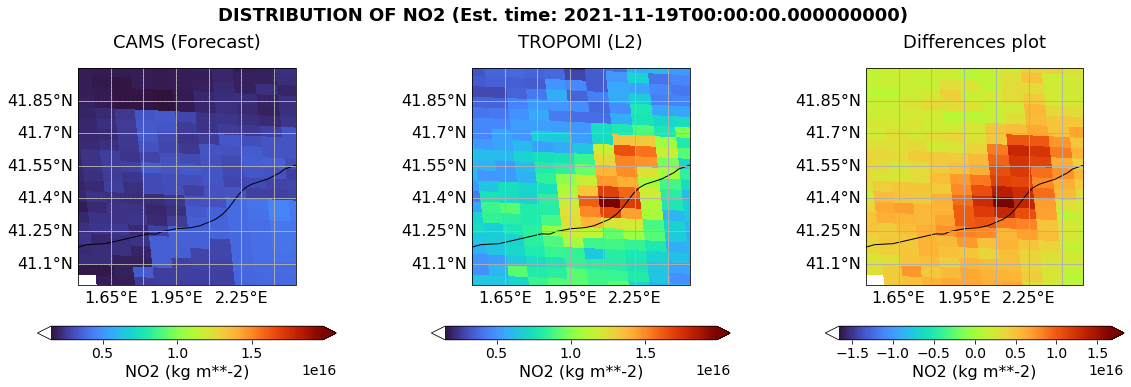

In [ ]:
# Choose distribution (aggregated, individual or animated)
distribution_type = 'individual'

# Choose range (original, equal or manual)
range_type = 'equal'
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'turbo' 

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_table, plot_dates, plot_bbox, 20, 1.05, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, vmin_manual, vmax_manual)

### Retrieve nearest values to specific latitude and longitude

In [ ]:
coords_search_list = (50, 60,
                      4, 10,
                      20, 30)
retrieval_table_all =  retrieve_coords(merge_table.dropna(), coords_search_list, component_nom, 
                                       sensor, model, plot_dates, units)
retrieval_table_all

,,,,,ground_pixel,scanline,model_column,sensor_column,difference
lat_search,lon_search,latitude,longitude,time,,,,,
50,60,41.994854,2.458288,2021-11-19,442.0,283.0,2.264212e+15,5.127722e+15,2.863510e+15
4,10,40.980755,2.563264,2021-11-19,442.0,262.0,3.667803e+15,4.418666e+15,7.508638e+14
20,30,40.980755,2.563264,2021-11-19,442.0,262.0,3.667803e+15,4.418666e+15,7.508638e+14


### Scatter plots by bbox

Fit equation: NO2_model = NO2_sensor * 0.11 + (1.80E+15)
Coefficient of determination (R2): 0.29


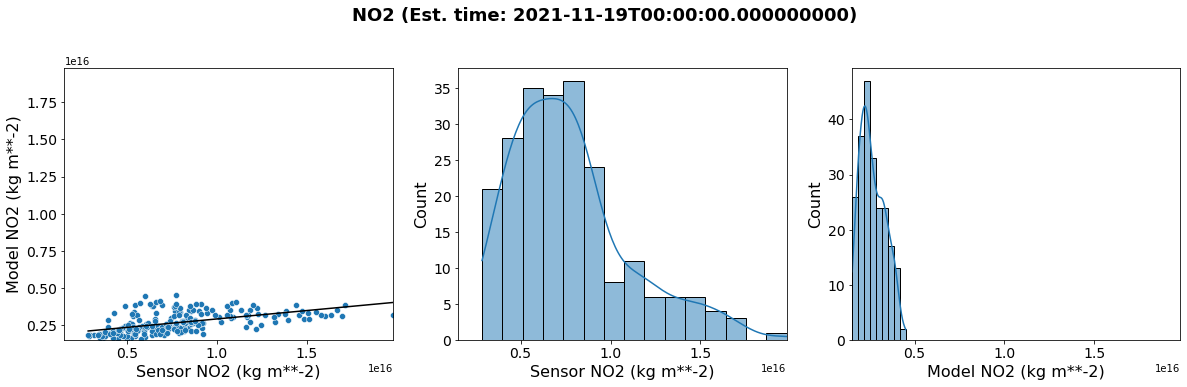

In [ ]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [ ]:
summary

,Period,Location,Score,Coefficient,Intercept
0,2021-11-19,"((1.5, 41), (2.5, 42))",0.287911,0.112911,1.804372e+15


### Scatter plots by season

Fit equation: NO2_model = NO2_sensor * 0.11 + (1.80E+15)
Coefficient of determination (R2): 0.29


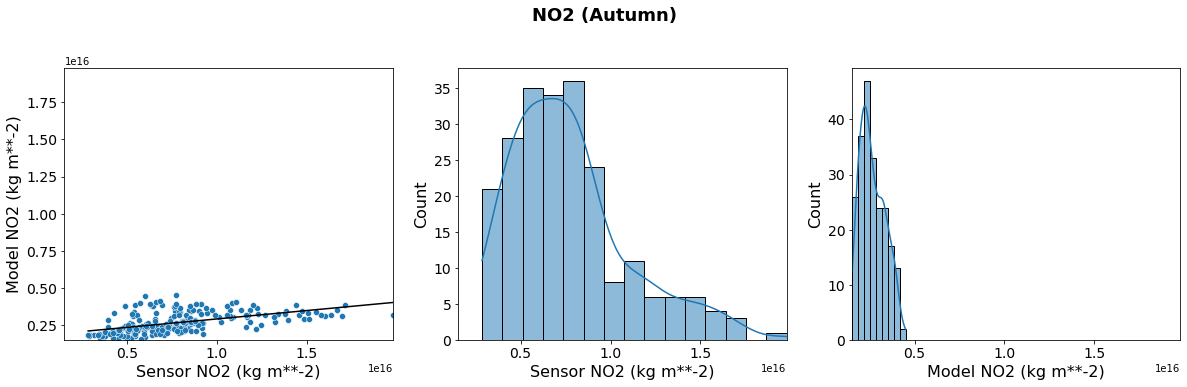

In [ ]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [ ]:
summary

,Period,Location,Score,Coefficient,Intercept
0,Autumn,"((1.5, 41), (2.5, 42))",0.287911,0.112911,1.804372e+15


<img src='images/Joint_school_logo_line.png' align='center' width='100%'></img>